## GNN_DTI Based Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader                                     
from gnn import gnn
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics
import utils
from train_tools import *
import os, time, shutil
from IPython.display import clear_output

In [3]:
class Opts: pass

### Options

In [4]:
gnn_opts = Opts()
gnn_opts.n_graph_layer = 4
gnn_opts.d_graph_layer = 140
gnn_opts.n_FC_layer = 4
gnn_opts.d_FC_layer = 128
gnn_opts.initial_mu = 4.46108546619827
gnn_opts.initial_dev = 0.19818493842903845
gnn_opts.dropout_rate = 0.2

In [5]:
learn_opts = Opts()
learn_opts.num_epochs = 1000
learn_opts.lr = 0.0001
learn_opts.batch_size = 64

In [6]:
myopts = Opts()
myopts.data_fpath = 'cbidata'
myopts.save_dir = 'save'
myopts.random_stratify = True
myopts.cache_dir = '/tmp/moldata'
myopts.clear_cache = False              # If you repeat experiments within the same dataset version, set to False
myopts.train_keys = 'keys/keys_refined'
myopts.kinase_list = 'keys/kinase_list'
myopts.dataset_version = 2              # <- The newest is 3, still 1 and 2 are acceptible
myopts.cpu_count = 10

In [7]:
assert myopts.dataset_version in [1, 2, 3]
_ver = myopts.dataset_version
if _ver == 1:
    import dataset as ds
elif _ver == 2:
    import dataset2 as ds
else:
    import dataset3 as ds

### Support functions for learning loop

In [8]:
def learn(model, loader, train=True):
    losses = []
    for sample in loader:
        model.zero_grad()
        H, A1, A2, Y, V, keys, _ = sample
        H, A1, A2, Y, V = H.to(device), A1.to(device), A2.to(device), Y.to(device), V.to(device)

        pred = model.train_model((H, A1, A2, V))

        loss = loss_fn(pred, Y)
        if train:
            loss.backward()
            optimizer.step()
        losses.append(loss.data.cpu().numpy())
    mean_loss = np.mean(np.array(losses))
    return mean_loss

def test(model, loader):
    test_true, test_pred, test_label = [], [], []

    saliency_list = []
    n_atom_list = []

    model.eval()
    for i_batch, sample in enumerate(loader):
        model.zero_grad()
        H, A1, A2, Y, V, keys, n_atom = sample

        embed = model.embede(H)
        model.zero_grad()
        pred = model.test_model((embed, A1, A2, V))

        out = torch.sum(pred)
        embed.retain_grad()
        out.backward()
        saliency = embed.grad.clone()
        saliency *= embed.data.clone()

        test_true.append(Y.data.cpu().numpy())
        test_pred.append(pred.data.cpu().numpy())
        test_label.append(keys)
        saliency_list.append(saliency)
        n_atom_list.append(n_atom)

    test_pred = np.concatenate(np.array(test_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    return test_true, test_pred, test_label, saliency_list, n_atom_list

def get_stats(X, y):
    rmse = metrics.mean_squared_error(X, y)**0.5
    mae = metrics.mean_absolute_error(X, y)
    r2 = stats.pearsonr(X, y)
    rho = stats.spearmanr(X, y)
    return rmse, mae, r2[0], rho[0]

def update_train_loss(train_loss, best_train_loss):
    if train_loss < best_train_loss:
        best_train_loss = train_loss
    return best_train_loss

def update_test_loss(model, opts, test_loss, best_val_loss, epoch):
    output = False
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        output = True
    if output:
        torch.save(model.state_dict(), f'{opts.save_dir}/save_{epoch}.pt')
        torch.save(model.state_dict(), f'{opts.save_dir}/model_weights.pt')
    return best_val_loss, output

### Setup

In [9]:
if myopts.clear_cache:
    try:
        shutil.rmtree(myopts.cache_dir)
    except:
        pass

In [10]:
os.makedirs(myopts.save_dir, exist_ok=True)

train = read_keyfile(myopts.train_keys)
train_keys, test_keys, test2_keys = filter_and_stratify(train, random_stratify=myopts.random_stratify)

write_keys(train_keys, 'train.local.key')
write_keys(test_keys, 'test.local.key')
write_keys(test2_keys, 'test2.local.key')

len(train_keys), len(test_keys), len(test2_keys)

(202, 50, 75)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [12]:
train_dataset = ds.MolDataset([k for k, v in train_keys], [v for k, v in train_keys], myopts.data_fpath)
test_dataset = ds.MolDataset([k for k, v in train_keys], [v for k, v in test_keys], myopts.data_fpath)
len(train_dataset), len(test_dataset)

(202, 50)

In [13]:
gnn_opts.N_atom_features = train_dataset[0]['H'].shape[1]//2

In [14]:
train_dataloader = DataLoader(train_dataset, learn_opts.batch_size, shuffle=True, num_workers=myopts.cpu_count, collate_fn=ds.collate_fn)
test_dataloader = DataLoader(test_dataset, learn_opts.batch_size, shuffle=True, num_workers=myopts.cpu_count, collate_fn=ds.collate_fn)

### Start Learning

number of parameters :  215567
Epoch: 0	Lapse: 3.7s	Losses: (52.381, 58.062)	Best: (52.381, 58.062)


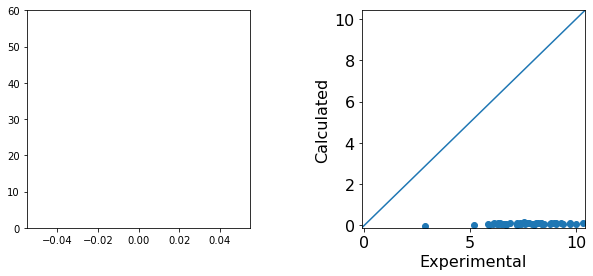

rmse: 7.620, mae: 7.499, r2: 0.464, rho: 0.338
--- Too many off-valued molecules ---

Epoch: 1	Lapse: 4.8s	Losses: (52.114, 55.749)	Best: (52.114, 55.749)


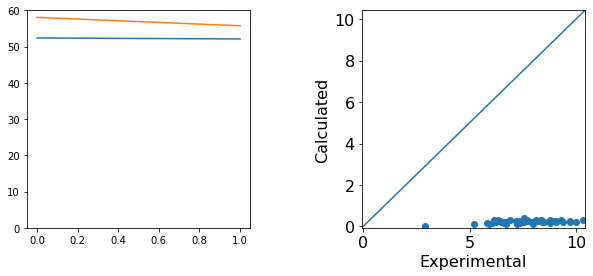

rmse: 7.467, mae: 7.346, r2: 0.439, rho: 0.313
--- Too many off-valued molecules ---

Epoch: 2	Lapse: 4.5s	Losses: (52.115, 53.432)	Best: (52.114, 53.432)


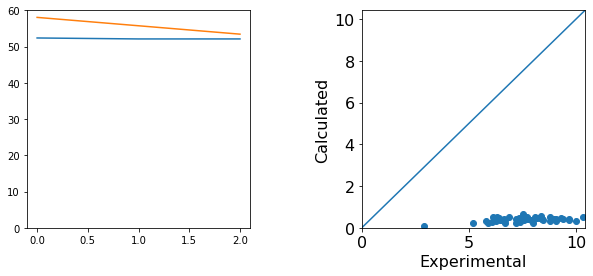

rmse: 7.310, mae: 7.189, r2: 0.431, rho: 0.302
--- Too many off-valued molecules ---

Epoch: 3	Lapse: 4.8s	Losses: (46.114, 50.999)	Best: (46.114, 50.999)


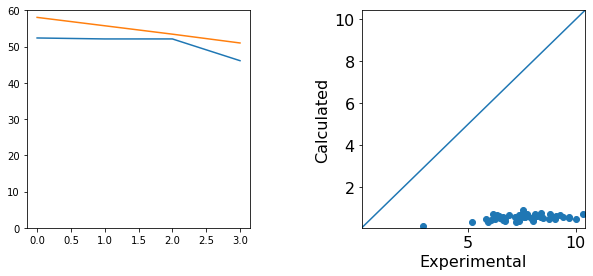

rmse: 7.141, mae: 7.019, r2: 0.426, rho: 0.296
--- Too many off-valued molecules ---

Epoch: 4	Lapse: 4.7s	Losses: (47.413, 48.241)	Best: (46.114, 48.241)


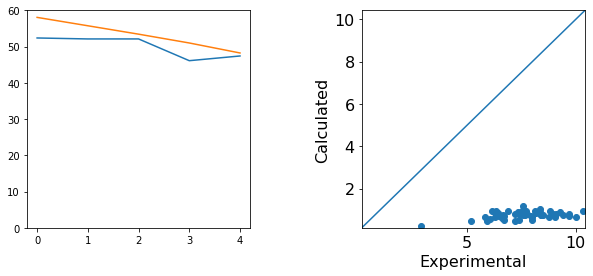

rmse: 6.946, mae: 6.822, r2: 0.421, rho: 0.284
--- Too many off-valued molecules ---

Epoch: 5	Lapse: 4.6s	Losses: (42.739, 45.137)	Best: (42.739, 45.137)


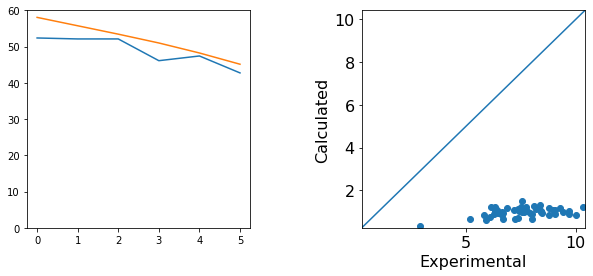

rmse: 6.718, mae: 6.593, r2: 0.417, rho: 0.276
--- Too many off-valued molecules ---

Epoch: 6	Lapse: 4.4s	Losses: (38.942, 41.737)	Best: (38.942, 41.737)


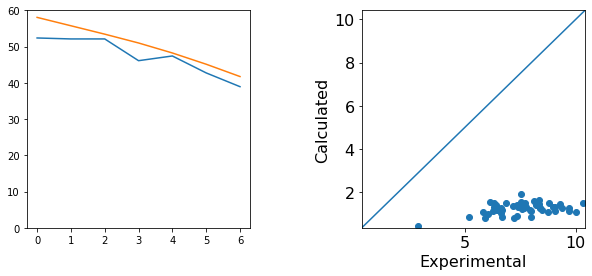

rmse: 6.460, mae: 6.332, r2: 0.410, rho: 0.268
--- Too many off-valued molecules ---

Epoch: 7	Lapse: 4.8s	Losses: (35.529, 38.014)	Best: (35.529, 38.014)


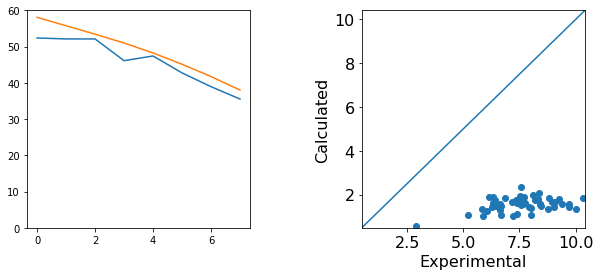

rmse: 6.166, mae: 6.033, r2: 0.403, rho: 0.265
--- Too many off-valued molecules ---

Epoch: 8	Lapse: 4.7s	Losses: (32.608, 33.625)	Best: (32.608, 33.625)


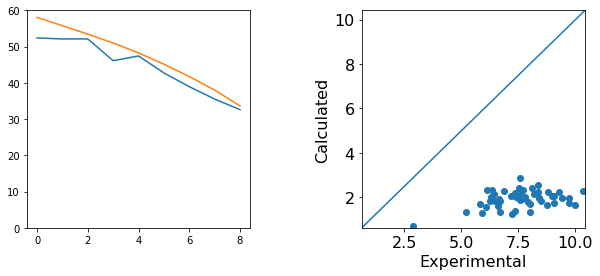

rmse: 5.799, mae: 5.659, r2: 0.395, rho: 0.251
--- Too many off-valued molecules ---

Epoch: 9	Lapse: 4.8s	Losses: (27.499, 28.360)	Best: (27.499, 28.360)


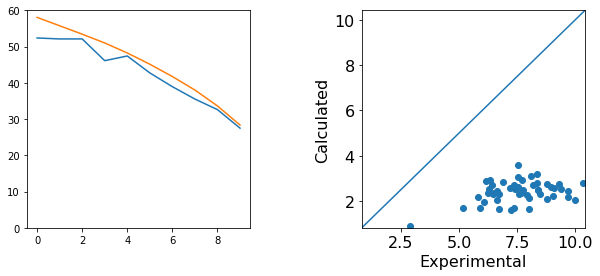

rmse: 5.325, mae: 5.173, r2: 0.381, rho: 0.222
--- Too many off-valued molecules ---

Epoch: 10	Lapse: 4.7s	Losses: (23.589, 21.898)	Best: (23.589, 21.898)


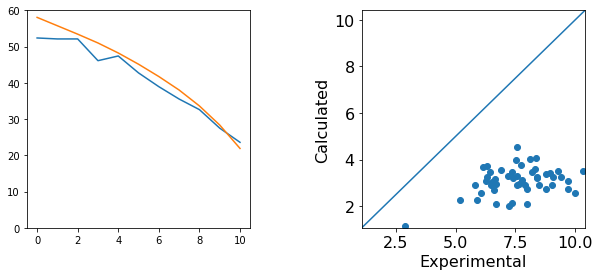

rmse: 4.680, mae: 4.501, r2: 0.355, rho: 0.209
--- Too many off-valued molecules ---

Epoch: 11	Lapse: 5.1s	Losses: (17.349, 14.089)	Best: (17.349, 14.089)


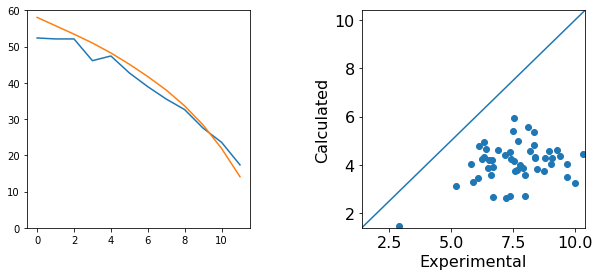

rmse: 3.754, mae: 3.502, r2: 0.313, rho: 0.163
--- Too many off-valued molecules ---

Epoch: 12	Lapse: 5.0s	Losses: (10.036, 6.183)	Best: (10.036, 6.183)


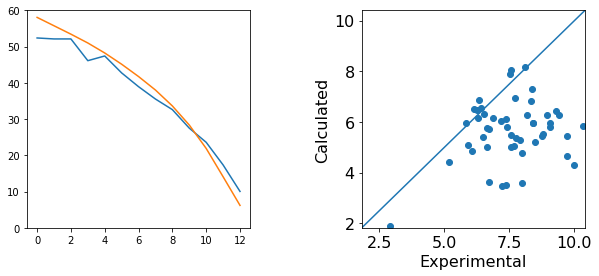

rmse: 2.487, mae: 2.020, r2: 0.246, rho: 0.047
--- Too many off-valued molecules ---

Epoch: 13	Lapse: 4.5s	Losses: (5.103, 4.032)	Best: (5.103, 4.032)


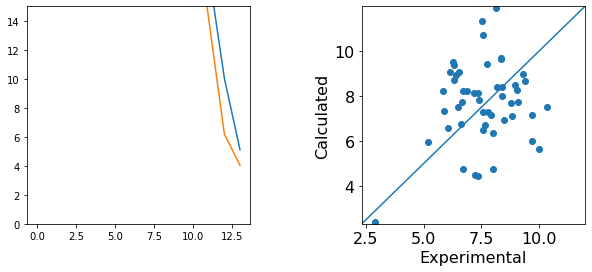

rmse: 2.008, mae: 1.652, r2: 0.190, rho: 0.004


4ivc,10.000,4.352
4fk6,9.700,3.693
4ehz,8.000,3.255
6g37,7.370,2.937
5h8g,10.320,2.798
4gfm,7.220,2.730
5dxt,9.700,2.546


Epoch: 14	Lapse: 4.8s	Losses: (7.155, 4.758)	Best: (5.103, 4.032)
Epoch: 15	Lapse: 4.9s	Losses: (5.058, 3.240)	Best: (5.058, 3.240)


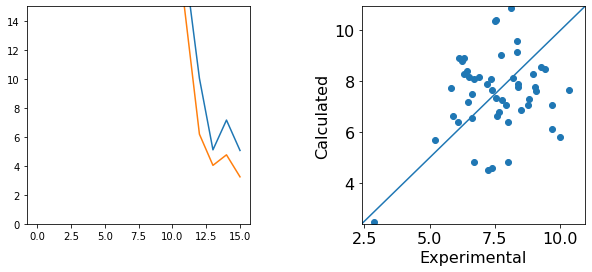

rmse: 1.800, mae: 1.497, r2: 0.247, rho: 0.051


4ivc,10.000,4.183
4fk6,9.700,3.578
4ehz,8.000,3.177
6g37,7.370,2.791
4gfm,7.220,2.702
5h8g,10.320,2.674
5dxt,9.700,2.618


Epoch: 16	Lapse: 4.5s	Losses: (3.821, 4.865)	Best: (3.821, 3.240)
Epoch: 17	Lapse: 4.8s	Losses: (5.339, 4.847)	Best: (3.821, 3.240)
Epoch: 18	Lapse: 4.6s	Losses: (5.085, 4.020)	Best: (3.821, 3.240)
Epoch: 19	Lapse: 5.0s	Losses: (5.870, 3.356)	Best: (3.821, 3.240)
Epoch: 20	Lapse: 4.8s	Losses: (4.243, 3.016)	Best: (3.821, 3.016)


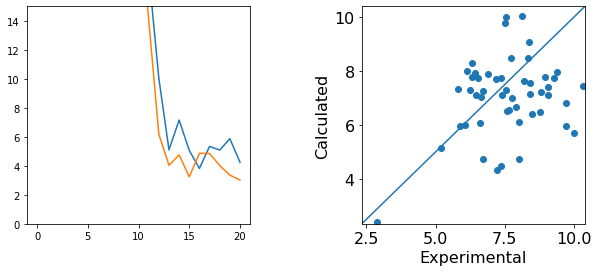

rmse: 1.737, mae: 1.426, r2: 0.294, rho: 0.084


4ivc,10.000,4.291
4fk6,9.700,3.729
4ehz,8.000,3.266
6g37,7.370,2.890
4gfm,7.220,2.889
5dxt,9.700,2.883
5h8g,10.320,2.878


Epoch: 21	Lapse: 4.7s	Losses: (4.875, 2.875)	Best: (3.821, 2.875)


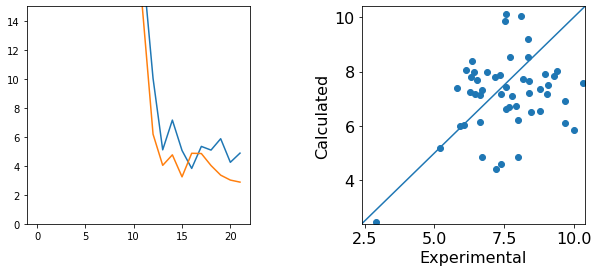

rmse: 1.696, mae: 1.394, r2: 0.308, rho: 0.112


4ivc,10.000,4.152
4fk6,9.700,3.599
4ehz,8.000,3.156
4gfm,7.220,2.813
6g37,7.370,2.793
5dxt,9.700,2.776
5h8g,10.320,2.759


Epoch: 22	Lapse: 4.5s	Losses: (3.897, 2.794)	Best: (3.821, 2.794)


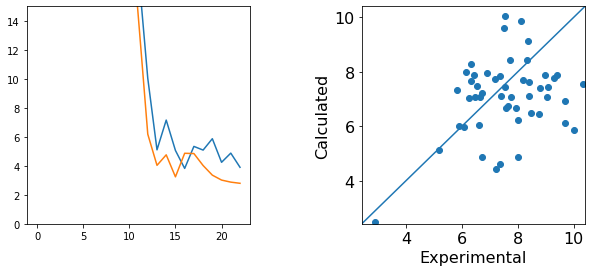

rmse: 1.672, mae: 1.368, r2: 0.325, rho: 0.128


4ivc,10.000,4.122
4fk6,9.700,3.565
4ehz,8.000,3.128
4gfm,7.220,2.809
5dxt,9.700,2.784
6g37,7.370,2.756
5h8g,10.320,2.755


Epoch: 23	Lapse: 5.0s	Losses: (2.921, 2.699)	Best: (2.921, 2.699)


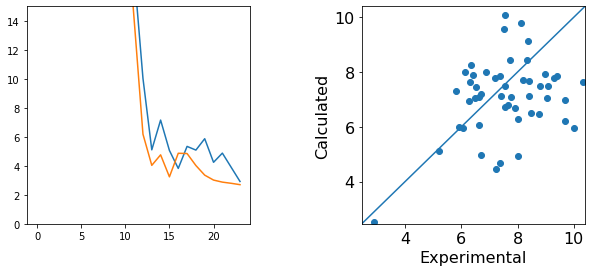

rmse: 1.643, mae: 1.343, r2: 0.338, rho: 0.143


4ivc,10.000,4.045
4fk6,9.700,3.485
4ehz,8.000,3.061
4gfm,7.220,2.775
5dxt,9.700,2.732
6g37,7.370,2.693
5h8g,10.320,2.688


Epoch: 24	Lapse: 4.5s	Losses: (4.402, 2.655)	Best: (2.921, 2.655)


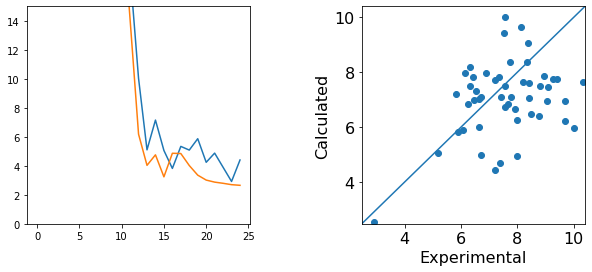

rmse: 1.629, mae: 1.324, r2: 0.353, rho: 0.160


4ivc,10.000,4.031
4fk6,9.700,3.467
4ehz,8.000,3.047
4gfm,7.220,2.785
5dxt,9.700,2.742
5h8g,10.320,2.685
6g37,7.370,2.671


Epoch: 25	Lapse: 4.7s	Losses: (3.692, 2.667)	Best: (2.921, 2.655)
Epoch: 26	Lapse: 4.9s	Losses: (3.337, 2.596)	Best: (2.921, 2.596)


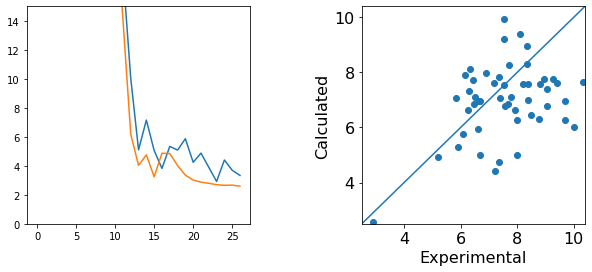

rmse: 1.611, mae: 1.307, r2: 0.380, rho: 0.194


4ivc,10.000,3.987
4fk6,9.700,3.422
4ehz,8.000,3.011
4gfm,7.220,2.790
5dxt,9.700,2.745
5h8g,10.320,2.660
6g37,7.370,2.619


Epoch: 27	Lapse: 4.8s	Losses: (3.083, 2.493)	Best: (2.921, 2.493)


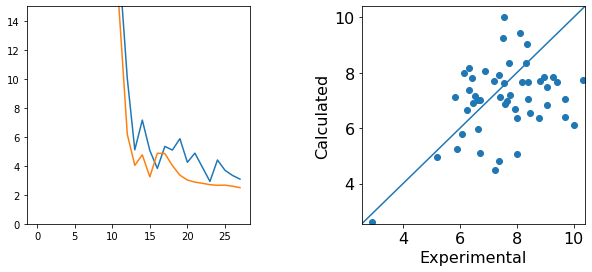

rmse: 1.579, mae: 1.286, r2: 0.389, rho: 0.202


4ivc,10.000,3.883
4fk6,9.700,3.315
4ehz,8.000,2.918
4gfm,7.220,2.734
5dxt,9.700,2.660
5h8g,10.320,2.566
6g37,7.370,2.541


Epoch: 28	Lapse: 5.0s	Losses: (3.590, 2.403)	Best: (2.921, 2.403)


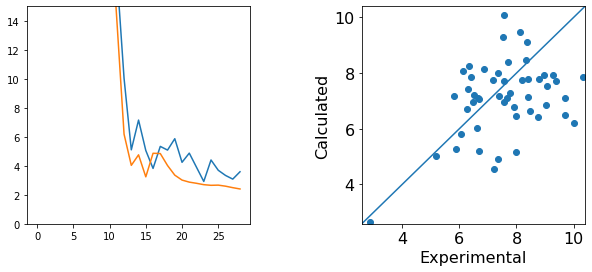

rmse: 1.550, mae: 1.267, r2: 0.397, rho: 0.208


4ivc,10.000,3.782
4fk6,9.700,3.215
4ehz,8.000,2.828
4gfm,7.220,2.681
5dxt,9.700,2.580


Epoch: 29	Lapse: 4.6s	Losses: (3.214, 2.434)	Best: (2.921, 2.403)
Epoch: 30	Lapse: 5.7s	Losses: (3.469, 2.519)	Best: (2.921, 2.403)
Epoch: 31	Lapse: 5.2s	Losses: (3.573, 2.508)	Best: (2.921, 2.403)
Epoch: 32	Lapse: 5.0s	Losses: (3.349, 2.375)	Best: (2.921, 2.375)


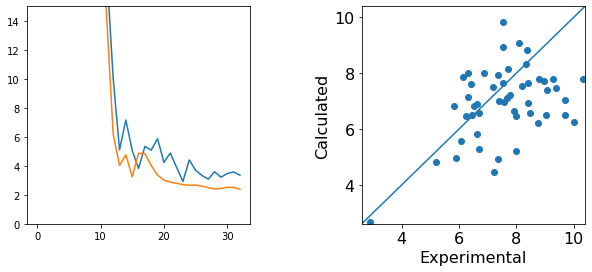

rmse: 1.541, mae: 1.232, r2: 0.435, rho: 0.271


4ivc,10.000,3.751
4fk6,9.700,3.193
4ehz,8.000,2.789
4gfm,7.220,2.741
5dxt,9.700,2.664
5wal,8.770,2.545
5h8g,10.320,2.540
4uja,9.050,2.538


Epoch: 33	Lapse: 5.4s	Losses: (3.218, 2.323)	Best: (2.921, 2.323)


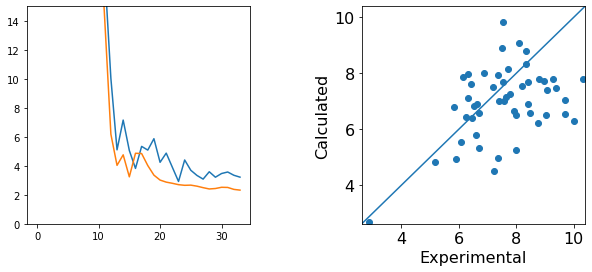

rmse: 1.524, mae: 1.218, r2: 0.445, rho: 0.279


4ivc,10.000,3.691
4fk6,9.700,3.141
4ehz,8.000,2.737
4gfm,7.220,2.724
5dxt,9.700,2.642
4uja,9.050,2.553
5wal,8.770,2.543
5h8g,10.320,2.516


Epoch: 34	Lapse: 5.4s	Losses: (2.862, 2.306)	Best: (2.862, 2.306)


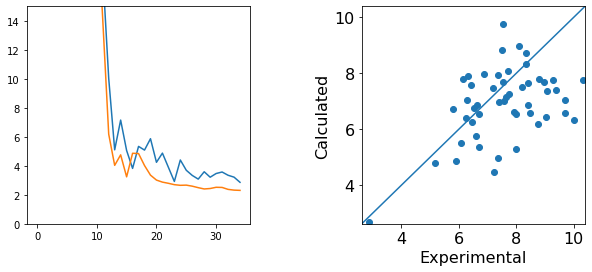

rmse: 1.519, mae: 1.212, r2: 0.456, rho: 0.285


4ivc,10.000,3.658
4fk6,9.700,3.113
4gfm,7.220,2.731
4ehz,8.000,2.705
5dxt,9.700,2.655
4uja,9.050,2.609
5wal,8.770,2.578
5h8g,10.320,2.537


Epoch: 35	Lapse: 4.5s	Losses: (3.140, 2.323)	Best: (2.862, 2.306)
Epoch: 36	Lapse: 4.8s	Losses: (3.728, 2.316)	Best: (2.862, 2.306)
Epoch: 37	Lapse: 5.0s	Losses: (3.921, 2.151)	Best: (2.862, 2.151)


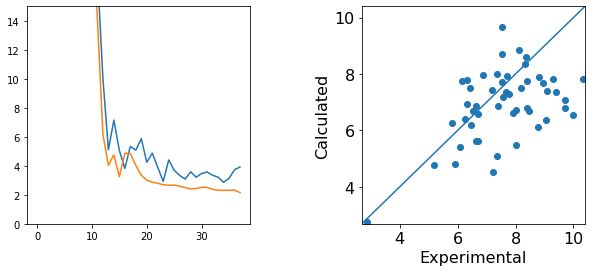

rmse: 1.467, mae: 1.156, r2: 0.495, rho: 0.353


4ivc,10.000,3.444
4fk6,9.700,2.919
4gfm,7.220,2.694
4uja,9.050,2.684
5wal,8.770,2.634
5dxt,9.700,2.604
5h8g,10.320,2.510
4ehz,8.000,2.510


KeyboardInterrupt: 

In [15]:
CLEAR_OUTPUT_WHEN_UPDATE = False
SHOW_VERY_BAD_MOLS = True

model = utils.initialize_model(gnn(gnn_opts), device)
print ('number of parameters : ', sum(p.numel() for p in model.parameters() if p.requires_grad))
optimizer = torch.optim.Adam(model.parameters(), lr=learn_opts.lr)
loss_fn = nn.MSELoss()
best_train_loss, best_val_loss = np.inf, np.inf

Los = []
Lps = []

for epoch in range(learn_opts.num_epochs):
    st = time.time()
    train_losses, test_losses = [], []

    model.train()
    train_loss = learn(model, train_dataloader)
    Los.append(train_loss)

    model.eval()
    test_loss = learn(model, test_dataloader, train=False)
    Lps.append(test_loss)

    lapse = time.time() - st

    best_train_loss = update_train_loss(train_loss, best_train_loss)
    best_val_loss, output = update_test_loss(model, myopts, test_loss, best_val_loss, epoch)

    ls = [f'Epoch: {epoch}',
          f'Lapse: {lapse:.1f}s',
          f'Losses: ({train_loss:.3f}, {test_loss:.3f})',
          f'Best: ({best_train_loss:.3f}, {best_val_loss:.3f})']
    print('\t'.join(ls))

    if output:
        X, y, L, S, N = test(model, test_dataloader)
        write_results_to_csv(L[0], X, y, np.abs(X-y), epoch)

        rmse, mae, r2, rho = get_stats(X, y)
        if CLEAR_OUTPUT_WHEN_UPDATE:
            clear_output()
        myplot(X, y, Los, Lps)
        print(f'rmse: {rmse:5.3f}, mae: {mae:5.3f}, r2: {r2:5.3f}, rho: {rho:5.3f}')
        if SHOW_VERY_BAD_MOLS:
            show_bad_molecules(L, X, y, np.abs(X-y), len(X))